In [35]:
import pandas as pd

def parse_recipes(file_path, label):
    recipes = []
    with open(file_path, 'r') as file:
        content = file.read()
        raw_recipes = content.strip().split('\n\n')
        
        for raw_recipe in raw_recipes:
            title, ingredients, instructions = None, None, None
            
            if 'Recipe:' in raw_recipe:
                sections = raw_recipe.split('Ingredients:')
                if len(sections) > 1:
                    title = sections[0].replace('Recipe:', '').strip()
                    ingredients_instructions = sections[1].split('Instructions:')
                    if len(ingredients_instructions) > 1:
                        ingredients = ingredients_instructions[0].strip()
                        instructions = ingredients_instructions[1].strip()
            
            if title and ingredients and instructions:
                recipes.append({
                    'meal_name': title,
                    'ingredients': ingredients,
                    'instructions': instructions,
                })
    
    return recipes


fitness_recipes = parse_recipes('recipes_data/fitness_recipes.txt', 'fitness')

df = pd.DataFrame(fitness_recipes)


df.to_csv('recipes.csv', index=False)

df.head()

,meal_name,ingredients,instructions
0,Egg Casserole,6 oz bacon diced (about 5 slices)\n1 cup onion...,Preheat oven to 350 degrees F.\nGrease a 9x13”...
1,No-Bake Chocolate Peanut Butter Cookies,½ cup creamy peanut butter\n¼ cup honey (or ma...,"Line a cookie sheet with waxed paper, set asid..."
2,Banana Oatmeal Cookies,3 bananas overripe (about 1 ¼ cups mashed bana...,Preheat oven to 350 degrees F. Line two baking...
3,Chocolate Date Energy Balls,2 cups pitted dates\n½ cup raw pecans\n½ cup r...,"Line a baking pan with wax paper, set aside. (..."
4,Pistachio Chicken,2 pounds chicken breasts cut into strips (or c...,Preheat oven to 425 degrees F.\nGrease two lar...


In [36]:
import pandas as pd

def parse_recipes(file_path, label):
    recipes = []
    with open(file_path, 'r') as file:
        content = file.read()
        raw_recipes = content.strip().split('\n\n')
        
        for raw_recipe in raw_recipes:
            title, ingredients, instructions = None, None, None
            
            if 'Recipe:' in raw_recipe:
                sections = raw_recipe.split('Ingredients:')
                if len(sections) > 1:
                    title = sections[0].replace('Recipe:', '').strip()
                    ingredients_instructions = sections[1].split('Instructions:')
                    if len(ingredients_instructions) > 1:
                        ingredients = ingredients_instructions[0].strip()
                        instructions = ingredients_instructions[1].strip()
            
            if title and ingredients and instructions:
                recipes.append({
                    'title': title,
                    'ingredients': ingredients,
                    'instructions': instructions,
                    'label': label
                })
    
    return recipes


regular_recipes = parse_recipes('recipes_data/regular_recipes.txt', 'regular')
fitness_recipes = parse_recipes('recipes_data/fitness_recipes.txt', 'fitness')


all_recipes = regular_recipes + fitness_recipes
df = pd.DataFrame(all_recipes)


df.to_csv('labeled_recipes.csv', index=False)

print("Data prepared for modeling:")
df.head()

Data prepared for modeling:


,title,ingredients,instructions,label
0,Best Meatloaf,2 pounds ground beef\n¼ cup bread crumbs (1 sl...,Preheat oven to 375°F (175°C).\nCombine ketchu...,regular
1,Chicken Lo Mein,1 pound chicken breasts\n8 ounces dry lo mein ...,"In a small bowl, whisk together sauce ingredie...",regular
2,Easy Homemade Mac and Cheese,8 ounces elbow macaroni uncooked\nCheese Sauce...,Cook elbow macaroni according to package instr...,regular
3,Chocolate Cake,1 ¼ cups all-purpose flour\n1 ¼ cups granulate...,Preheat oven to 350 degrees F.\nLine two 6” ro...,regular
4,Crock Pot Teriyaki Chicken,2 pounds chicken breasts\n½ cup honey\n¾ cup s...,Grease the container of a large slow cooker.\n...,regular


In [37]:
import re

def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text


df['ingredients'] = df['ingredients'].apply(clean_text)
df['instructions'] = df['instructions'].apply(clean_text)

In [38]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


df = pd.read_csv('labeled_recipes.csv')
def extract_quantity(ingredient):
    quantities = re.findall(r'\d+\/\d+|\d+\.\d+|\d+', ingredient)
    return sum([eval(q) for q in quantities]) if quantities else 0

df['ingredient_quantity'] = df['ingredients'].apply(lambda x: sum(extract_quantity(ing) for ing in x.split('\n')))

def clean_text(text):
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text


df['ingredients'] = df['ingredients'].apply(clean_text)
df['instructions'] = df['instructions'].apply(clean_text)

# We tested with max_features set to 50, but we obtained the same results.
vectorizer_ingredients = TfidfVectorizer(max_features=100) 
vectorizer_instructions = TfidfVectorizer(max_features=100)

X_ingredients = vectorizer_ingredients.fit_transform(df['ingredients']).toarray()
X_instructions = vectorizer_instructions.fit_transform(df['instructions']).toarray()


X = pd.concat([pd.DataFrame(X_ingredients), pd.DataFrame(X_instructions), df[['ingredient_quantity']]], axis=1)
y = df['label'].apply(lambda x: 1 if x == 'fitness' else 0)

X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.80      0.50      0.62         8

    accuracy                           0.78        23
   macro avg       0.79      0.72      0.73        23
weighted avg       0.79      0.78      0.77        23

Accuracy Score: 0.782608695652174


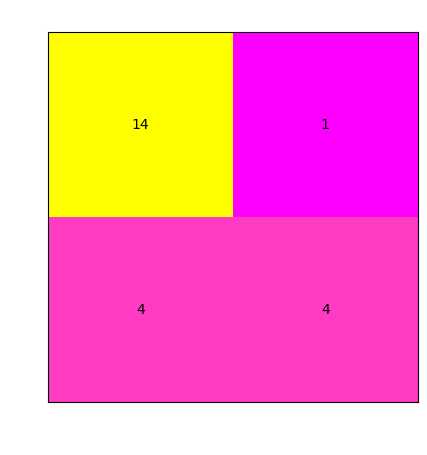

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='spring', ax=ax, colorbar=False)

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

for text in ax.texts:
    text.set_color("black")

plt.title('Confusion Matrix', color='white')

ax.xaxis.label.set_color("white") 
ax.yaxis.label.set_color("white") 
ax.tick_params(colors="white") 

plt.show()

In [40]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_test, y_test)
print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)

Training Accuracy: 0.5842696629213483
Validation Accuracy: 0.782608695652174


In [41]:
import re
from nltk.stem import PorterStemmer


stemmer = PorterStemmer()
fitness_substitutions = {
    "sugar": "stevia or honey",
    "butter": "coconut oil",
    "cream": "greek yogurt",
    "frying": "baking or grilling"
}

def generate_fitness_suggestions(text, fitness_substitutions):
    words = re.findall(r'\b\w+\b', text.lower())
    suggestions = []
    for word in words:
        stem = stemmer.stem(word)
        if stem == "fri":
            suggestion = f"How about trying a healthier option instead of frying, like {fitness_substitutions['frying']}? It’s a great way to enjoy your meals while making them even better for you!"
            suggestions.append(suggestion)
        elif word in fitness_substitutions:
            suggestion = f"Try swapping {word} for a tasty and healthier option like {fitness_substitutions[word]}. You'll love the change!"
            suggestions.append(suggestion)
    
    return suggestions


def update_feedback(recipe_text):
    if recipe_text:
        recipe_text_cleaned = clean_text(recipe_text)
        recipe_text_transformed_ingredients = vectorizer_ingredients.transform([recipe_text_cleaned]).toarray()
        recipe_text_transformed_instructions = vectorizer_instructions.transform([recipe_text_cleaned]).toarray()
        ingredient_quantity = sum([eval(q) for q in re.findall(r'\d+\/\d+|\d+\.\d+|\d+', recipe_text)]) if recipe_text else 0

        recipe_features = pd.concat(
            [
                pd.DataFrame(recipe_text_transformed_ingredients),
                pd.DataFrame(recipe_text_transformed_instructions),
                pd.DataFrame([ingredient_quantity], columns=["ingredient_quantity"])
            ],
            axis=1
        )
        recipe_features.columns = recipe_features.columns.astype(str)

        prediction = model.predict(recipe_features)

        if prediction[0] == 1:
            feedback = [
                "✅ This is a fitness recipe! This meal is perfect for staying fit and healthy!"
            ]
        else:
            feedback = [
                "❌ This is not a fitness recipe!"
            ]
            suggestions = generate_fitness_suggestions(recipe_text, fitness_substitutions)
            if suggestions:
                feedback.append("This meal might not be the best option for your fitness goals, but don’t worry! Here are some friendly tips to make it a bit healthier:")
                feedback.extend(suggestions)
            else:
                feedback.append("This meal may not be the best choice for your fitness goals, but that's totally fine! Consider it a fun cheat meal! If you’re looking for more fitness-friendly food ideas, I highly recommend checking out the 'Fuel Your Day with Good Energy' cookbook by Tea. It’s filled with delicious options that you’ll love! Enjoy your meal!")

        for line in feedback:
            print(line)

recipe_text_example1 = "In a large skillet, heat oil over medium heat. Season the chicken pieces with salt, pepper, and paprika. Dredge them in flour, shaking off any excess. Fry the chicken in batches until golden brown and cooked through, about 5-7 minutes per side. Serve with mashed potatoes and steamed green beans."
update_feedback(recipe_text_example1)

❌ This is not a fitness recipe!
This meal might not be the best option for your fitness goals, but don’t worry! Here are some friendly tips to make it a bit healthier:
How about trying a healthier option instead of frying, like baking or grilling? It’s a great way to enjoy your meals while making them even better for you!


In [42]:
recipe_text_example2 = "For a hearty spaghetti bolognese, start by heating olive oil in a large pan over medium heat. Add 1 diced onion, 2 minced garlic cloves, and 1 grated carrot, cooking until softened. Add 500g ground beef, cooking until browned. Stir in 1 can of crushed tomatoes, 2 tablespoons tomato paste, 1 teaspoon dried oregano, and 1 teaspoon dried basil. Simmer for 20 minutes, seasoning with salt and pepper to taste. Serve over cooked spaghetti, garnished with grated Parmesan and fresh parsley."
update_feedback(recipe_text_example2)

✅ This is a fitness recipe! This meal is perfect for staying fit and healthy!


In [43]:
recipe_text_example3 = "For a grilled salmon and quinoa bowl, marinate 2 salmon fillets in a mixture of 2 tablespoons olive oil, 1 tablespoon lemon juice, 1 minced garlic clove, and a pinch of salt and pepper. Grill the salmon over medium heat for 4-5 minutes per side. Cook 1 cup quinoa according to package instructions and let cool. Assemble the bowl with quinoa, a handful of baby spinach, ½ avocado sliced, cherry tomatoes, and cucumber slices. Top with grilled salmon and drizzle with a light lemon-tahini dressing."
update_feedback(recipe_text_example3)

❌ This is not a fitness recipe!
This meal may not be the best choice for your fitness goals, but that's totally fine! Consider it a fun cheat meal! If you’re looking for more fitness-friendly food ideas, I highly recommend checking out the 'Fuel Your Day with Good Energy' cookbook by Tea. It’s filled with delicious options that you’ll love! Enjoy your meal!


In [44]:
recipe_text_example4 = "1 ½ cups all-purpose flour, 1 teaspoon baking powder, ½ teaspoon baking soda, ¼ teaspoon salt, ¾ cup granulated sugar, ½ cup unsalted butter, 2 large eggs, 1 teaspoon vanilla extract, ½ cup whole milk, ½ cup semi-sweet chocolate chips."
update_feedback(recipe_text_example4)

❌ This is not a fitness recipe!
This meal might not be the best option for your fitness goals, but don’t worry! Here are some friendly tips to make it a bit healthier:
Try swapping sugar for a tasty and healthier option like stevia or honey. You'll love the change!
Try swapping butter for a tasty and healthier option like coconut oil. You'll love the change!


In [47]:
dataset_recipe1='''vegetable oil for frying
4 cups all-purpose flour
6 tablespoons garlic salt
3 tablespoons ground black pepper
4 large eggs, beaten
8 skinless, boneless chicken breast halves - cut into small chunks.'''

update_feedback(dataset_recipe1)

❌ This is not a fitness recipe!
This meal might not be the best option for your fitness goals, but don’t worry! Here are some friendly tips to make it a bit healthier:
How about trying a healthier option instead of frying, like baking or grilling? It’s a great way to enjoy your meals while making them even better for you!


In [48]:
dataset_recipe2='''3-4 overripe bananas (1 ½ cups mashed)
½ cup salted butter melted
2 eggs beaten
2 teaspoons pure vanilla extract
¾ cup granulated sugar
¼ cup light brown sugar
1 ½ cups all-purpose flour
1 teaspoon baking soda
½ teaspoon baking powder
½ teaspoon fine sea salt
½ teaspoon cinnamon'''

update_feedback(dataset_recipe2)

❌ This is not a fitness recipe!
This meal might not be the best option for your fitness goals, but don’t worry! Here are some friendly tips to make it a bit healthier:
Try swapping butter for a tasty and healthier option like coconut oil. You'll love the change!
Try swapping sugar for a tasty and healthier option like stevia or honey. You'll love the change!
Try swapping sugar for a tasty and healthier option like stevia or honey. You'll love the change!


In [50]:
dataset_recipe3='''4 cups water
2 cups uncooked white rice
3 tablespoons soy sauce
2 tablespoons creamy peanut butter
2 teaspoons white wine vinegar
¼ teaspoon cayenne pepper
3 tablespoons olive oil
4 skinless, boneless chicken breast halves - cut into thin strips
3 tablespoons chopped garlic
1 ½ tablespoons chopped fresh ginger root
2 ½ cups broccoli florets
¾ cup chopped green onions
⅓ cup unsalted dry-roasted peanuts
Combine water and rice in a saucepan over medium-high heat; bring to a boil. Reduce heat to low, cover, and simmer until rice is tender and liquid is absorbed, about 20 minutes.
Meanwhile, stir together soy sauce, peanut butter, vinegar, and cayenne pepper in a small bowl; set aside.
Heat olive oil in a skillet or wok over high heat. Cook and stir chicken, garlic, and ginger in hot oil until chicken is lightly browned, about 5 minutes. Reduce heat to medium and add broccoli, green onions, peanuts, and soy sauce mixture. Cook, stirring frequently, until broccoli is tender and chicken is cooked through, about 5 minutes.
Serve chicken-broccoli mixture over cooked rice.'''

update_feedback(dataset_recipe3)

✅ This is a fitness recipe! This meal is perfect for staying fit and healthy!


In [52]:
dataset_recipe4='''40g Oats
30g Vanilla Whey protein
5g cacao powder
50g banana
15g Hershey Zero Sugar
Chocolate Baking Chips'''

update_feedback(dataset_recipe4)

✅ This is a fitness recipe! This meal is perfect for staying fit and healthy!
